### 3D Grounding with Qwen3-VL

This notebook showcases Qwen3-VL's advanced spatial understanding capabilities, including 3D object localization and specific target grounding within images.

See how it integrates visual and linguistic understanding to interpret complex 3D scenes effectively.


Prepare the environment

In [ ]:
# Install required dependencies
!pip install git+https://github.com/huggingface/transformers
!pip install qwen-vl-utils
!pip install openai
!pip install pillow
!pip install opencv-python
!pip install numpy
!pip install matplotlib


#### [Setup]

Load visualization utils.


In [2]:
# @title 3D Visualization Utilities

import json
import random
import io
import ast
import math
import cv2
import numpy as np
from PIL import ImageColor
import matplotlib.pyplot as plt
import os
import base64
from openai import OpenAI
from PIL import Image

def parse_bbox_3d_from_text(text: str) -> list:
    """
    Parse 3D bounding box information from assistant response.
    
    Args:
        text: Assistant response text containing JSON with bbox_3d information
        
    Returns:
        List of dictionaries containing bbox_3d data
    """
    try:
        # Find JSON content
        if "```json" in text:
            start_idx = text.find("```json")
            end_idx = text.find("```", start_idx + 7)
            if end_idx != -1:
                json_str = text[start_idx + 7:end_idx].strip()
            else:
                json_str = text[start_idx + 7:].strip()
        else:
            # Find first [ and last ]
            start_idx = text.find('[')
            end_idx = text.rfind(']')
            if start_idx != -1 and end_idx != -1:
                json_str = text[start_idx:end_idx + 1]
            else:
                return []
        
        # Parse JSON
        bbox_data = json.loads(json_str)
        
        # Normalize to list format
        if isinstance(bbox_data, list):
            return bbox_data
        elif isinstance(bbox_data, dict):
            return [bbox_data]
        else:
            return []
            
    except (json.JSONDecodeError, IndexError, KeyError):
        return []

def convert_3dbbox(point, cam_params):
    """Convert 3D bounding box to 2D image coordinates"""
    x, y, z, x_size, y_size, z_size, pitch, yaw, roll = point
    hx, hy, hz = x_size / 2, y_size / 2, z_size / 2
    local_corners = [
        [ hx,  hy,  hz],
        [ hx,  hy, -hz],
        [ hx, -hy,  hz],
        [ hx, -hy, -hz],
        [-hx,  hy,  hz],
        [-hx,  hy, -hz],
        [-hx, -hy,  hz],
        [-hx, -hy, -hz]
    ]

    def rotate_xyz(_point, _pitch, _yaw, _roll):
        x0, y0, z0 = _point
        x1 = x0
        y1 = y0 * math.cos(_pitch) - z0 * math.sin(_pitch)
        z1 = y0 * math.sin(_pitch) + z0 * math.cos(_pitch)

        x2 = x1 * math.cos(_yaw) + z1 * math.sin(_yaw)
        y2 = y1
        z2 = -x1 * math.sin(_yaw) + z1 * math.cos(_yaw)

        x3 = x2 * math.cos(_roll) - y2 * math.sin(_roll)
        y3 = x2 * math.sin(_roll) + y2 * math.cos(_roll)
        z3 = z2

        return [x3, y3, z3]
    
    img_corners = []
    for corner in local_corners:
        rotated = rotate_xyz(corner, np.deg2rad(pitch), np.deg2rad(yaw), np.deg2rad(roll))
        X, Y, Z = rotated[0] + x, rotated[1] + y, rotated[2] + z
        if Z > 0:
            x_2d = cam_params['fx'] * (X / Z) + cam_params['cx']
            y_2d = cam_params['fy'] * (Y / Z) + cam_params['cy']
            img_corners.append([x_2d, y_2d])

    return img_corners

def draw_3dbboxes(image_path, cam_params, bbox_3d_list, color=None):
    """Draw multiple 3D bounding boxes on the same image and return matplotlib figure"""
    # Read image
    annotated_image = cv2.imread(image_path)
    if annotated_image is None:
        print(f"Error reading image: {image_path}")
        return None

    edges = [
        [0,1], [2,3], [4,5], [6,7],
        [0,2], [1,3], [4,6], [5,7],
        [0,4], [1,5], [2,6], [3,7]
    ]
    
    # Draw 3D box for each bbox
    for bbox_data in bbox_3d_list:
        # Extract bbox_3d from the dictionary
        if isinstance(bbox_data, dict) and 'bbox_3d' in bbox_data:
            bbox_3d = bbox_data['bbox_3d']
        else:
            bbox_3d = bbox_data
        
        # Convert angles multiplied by 180 to degrees
        bbox_3d = list(bbox_3d)  # Convert to list for modification
        bbox_3d[-3:] = [_x * 180 for _x in bbox_3d[-3:]]
        bbox_2d = convert_3dbbox(bbox_3d, cam_params)

        if len(bbox_2d) >= 8:
            # Generate random color for each box
            box_color = [random.randint(0, 255) for _ in range(3)]
            for start, end in edges:
                try:
                    pt1 = tuple([int(_pt) for _pt in bbox_2d[start]])
                    pt2 = tuple([int(_pt) for _pt in bbox_2d[end]])
                    cv2.line(annotated_image, pt1, pt2, box_color, 2)
                except:
                    continue

    # Convert BGR to RGB for matplotlib
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    
    # Create matplotlib figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(annotated_image_rgb)
    ax.axis('off')
    
    return fig


## 3D Object Localization with Qwen3-VL

Qwen3-VL supports localizing specific 3D objects in images based on natural language descriptions. This notebook demonstrates various 3D grounding scenarios.

Because accurate 3D perception highly relies on camera parameters, please make sure you have camera intrinsic parameters (focal length fx, fy and principal point cx, cy) for better experience. If you don't have camera parameters, we will generate a group of general camera parameters with fov=60° for you to try this demo.

### 3D Bounding Box Format

We represent 3D bounding boxes as: `[x_center, y_center, z_center, x_size, y_size, z_size, roll, pitch, yaw]`

- **x_center, y_center, z_center**: Object center in camera coordinates (meters)
- **x_size, y_size, z_size**: Object dimensions (meters)  
- **roll, pitch, yaw**: Rotation angles (radians)


### Inference Function with API


In [ ]:
# Please replace the following model_id, api_key and base_url with your own.

def encode_image(image_path):
    """Encode image to base64 format"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def inference_with_api(image_path, prompt, 
                      model_id="your model here"):
    """API-based inference using custom endpoint"""
    base64_image = encode_image(image_path)
    client = OpenAI(
        api_key=os.getenv('DASHSCOPE_API_KEY'),
        base_url="https://dashscope-intl.aliyuncs.com/compatible-mode/v1",
    )

    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
                {"type": "text", "text": prompt},
            ],
        }
    ]
    completion = client.chat.completions.create(
        model = model_id,
        messages = messages,
    )
    return completion.choices[0].message.content


### Camera Parameters Generation

Note: When you don't have access to the original camera intrinsic parameters, we can generate general camera parameters with a field of view of 60° for demonstration purposes.


In [4]:
# Load camera parameters from JSON file
def load_camera_params(image_name):
    """Load camera parameters for a specific image from cam_infos.json"""
    with open('./assets/spatial_understanding/cam_infos.json', 'r') as f:
        cam_infos = json.load(f)
    return cam_infos.get(image_name, None)

def generate_camera_params(image_path, fx=None, fy=None, cx=None, cy=None, fov=60):
    """
    Generate camera parameters for 3D visualization.
    
    Args:
        image_path: Path to the image
        fx, fy: Focal lengths in pixels (if None, will be calculated from fov)
        cx, cy: Principal point coordinates in pixels (if None, will be set to image center)
        fov: Field of view in degrees (default: 60°)
    
    Returns:
        dict: Camera parameters with keys 'fx', 'fy', 'cx', 'cy'
    """
    image = Image.open(image_path)
    w, h = image.size
    
    # Generate pseudo camera params if not provided
    if fx is None or fy is None:
        fx = round(w / (2 * np.tan(np.deg2rad(fov) / 2)), 2)
        fy = round(h / (2 * np.tan(np.deg2rad(fov) / 2)), 2)
    
    if cx is None or cy is None:
        cx = round(w / 2, 2)
        cy = round(h / 2, 2)
    
    cam_params = {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}
    return cam_params


### 1. Detect Objects of Specific Categories


In [39]:
# Example 1: Detect all cars in autonomous driving scene
image_path = "./assets/spatial_understanding/autonomous_driving.jpg"
prompt = "Find all cars in this image. For each car, provide its 3D bounding box. The output format required is JSON: `[{\"bbox_3d\":[x_center, y_center, z_center, x_size, y_size, z_size, roll, pitch, yaw],\"label\":\"category\"}]`."

# Load camera parameters
cam_params = load_camera_params("autonomous_driving.jpg")

# Call API to get 3D bounding box results
response = inference_with_api(image_path, prompt)
bbox_3d_results = parse_bbox_3d_from_text(response)
print("Parsed bbox_3d_results:", bbox_3d_results)


Parsed bbox_3d_results: [{'bbox_3d': [2.88, 0.56, 6.28, 4.45, 1.7, 1.84, 0.75, 0.49, 0.75], 'label': 'car'}, {'bbox_3d': [2.83, 0.58, 14.78, 4.43, 1.56, 1.77, 0.82, 0.49, 0.82], 'label': 'car'}]


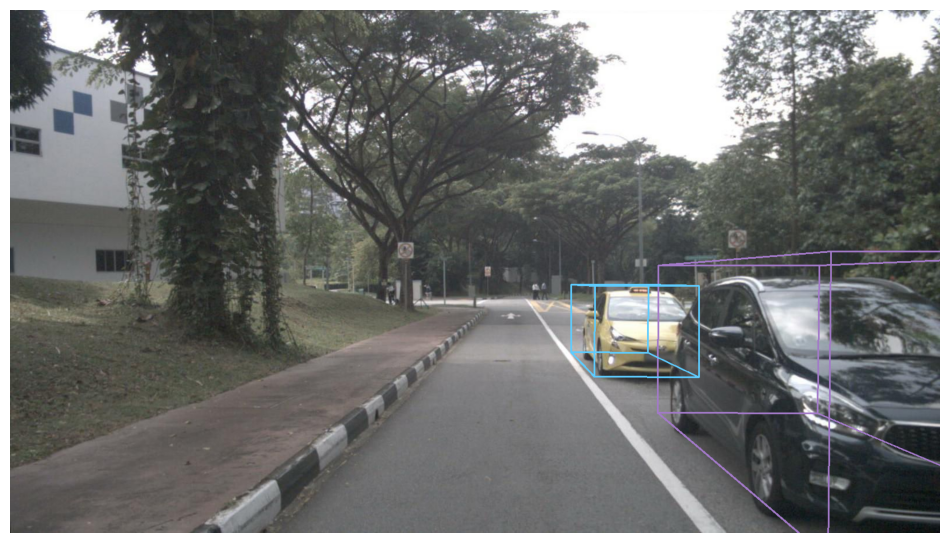

In [41]:
# Display the 3D bounding boxes visualization in notebook
fig = draw_3dbboxes(image_path, cam_params, bbox_3d_results)
if fig is not None:
    plt.show()


### 2. Detect a Specific Object Using Descriptions


In [7]:
# Example 2: Detect a specific object using descriptions
image_path = "./assets/spatial_understanding/office.jpg"
prompt = "Locate the black chair in image and provide 3D bounding boxes results in JSON format."

# Load camera parameters
cam_params = load_camera_params("office.jpg")

# Call API to get 3D bounding box results
response = inference_with_api(image_path, prompt)
bbox_3d_results = parse_bbox_3d_from_text(response)
print("Parsed bbox_3d_results:", bbox_3d_results)


Parsed bbox_3d_results: [{'bbox_3d': [-0.4, -0.26, 2.71, 0.76, 0.96, 0.78, 0.16, 0.13, 0.08], 'label': 'black chair'}]


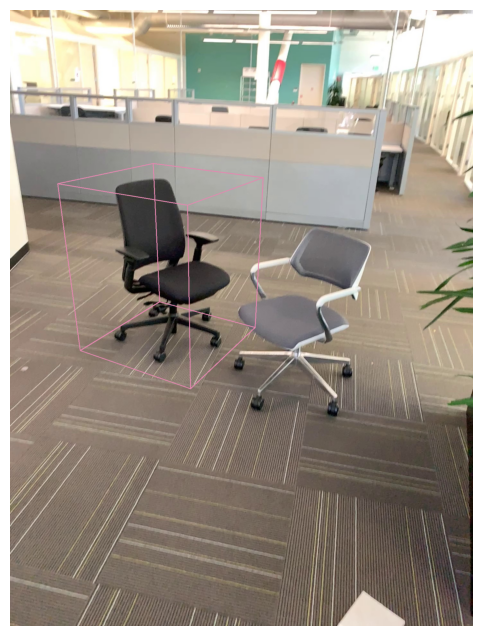

In [8]:
# Display the 3D bounding boxes visualization in notebook
fig = draw_3dbboxes(image_path, cam_params, bbox_3d_results)
if fig is not None:
    plt.show()


### 3. Detect Multiple Objects 


In [9]:
# Example 3: Detect multiple objects simultaneously
image_path = "./assets/spatial_understanding/lounge.jpg"
prompt = "在提供的图像里定位桌子、椅子和沙发，输出对应的三维边界框。格式为：[{\"bbox_3d\":[x_center, y_center, z_center, x_size, y_size, z_size, roll, pitch, yaw],\"label\":\"类别\"}]。"

# Load camera parameters
cam_params = load_camera_params("lounge.jpg")

# Call API to get 3D bounding box results
response = inference_with_api(image_path, prompt)
bbox_3d_results = parse_bbox_3d_from_text(response)
print("Parsed bbox_3d_results:", bbox_3d_results)


Parsed bbox_3d_results: [{'bbox_3d': [0.27, 0.13, 2.21, 0.69, 0.76, 1.8, 0.87, 0.09, 0.94], 'label': '桌子'}, {'bbox_3d': [0.18, 0.26, 1.71, 0.57, 0.78, 0.52, 0.13, -0.09, -0.06], 'label': '椅子'}, {'bbox_3d': [-0.04, -0.01, 2.39, 0.52, 0.76, 0.5, 0.13, -0.07, -0.05], 'label': '椅子'}, {'bbox_3d': [-0.83, -0.18, 2.87, 0.76, 0.76, 1.86, 0.28, 0.33, 0.23], 'label': '沙发'}]


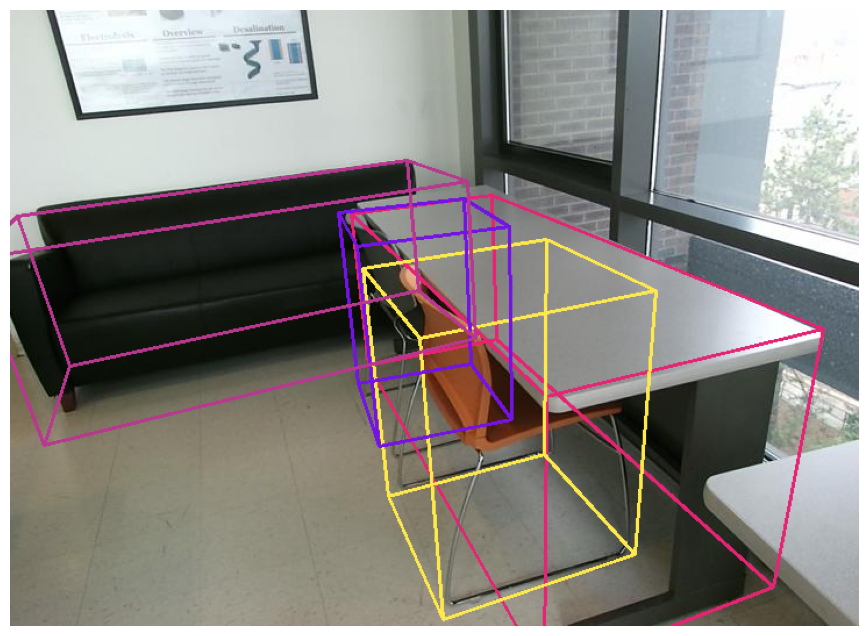

In [10]:
# Display the 3D bounding boxes visualization in notebook
fig = draw_3dbboxes(image_path, cam_params, bbox_3d_results)
if fig is not None:
    plt.show()


### 4. Using Custom Camera Parameters

When you don't have access to the original camera intrinsic parameters, you can use our camera parameter generation function. This example demonstrates how to detect objects using estimated camera parameters with a 60° field of view.


In [33]:
# Example 4: Using custom camera parameters
image_path = "./assets/spatial_understanding/manipulation.jpg"
prompt = "Detect the bottle in the image and predict the 3D box. Output JSON: [{\"bbox_3d\":[x_center, y_center, z_center, x_size, y_size, z_size, roll, pitch, yaw],\"label\":\"category\"}]."

# Generate camera parameters using our function (since we don't have original camera params)
cam_params = generate_camera_params(image_path, fov=60)

# Call API to get 3D bounding box results
response = inference_with_api(image_path, prompt)
bbox_3d_results = parse_bbox_3d_from_text(response)
print("Parsed bbox_3d_results:", bbox_3d_results)


Parsed bbox_3d_results: [{'bbox_3d': [0.04, -0.03, 0.66, 0.07, 0.22, 0.08, 0.76, 0.08, 0.94], 'label': 'bottle'}]


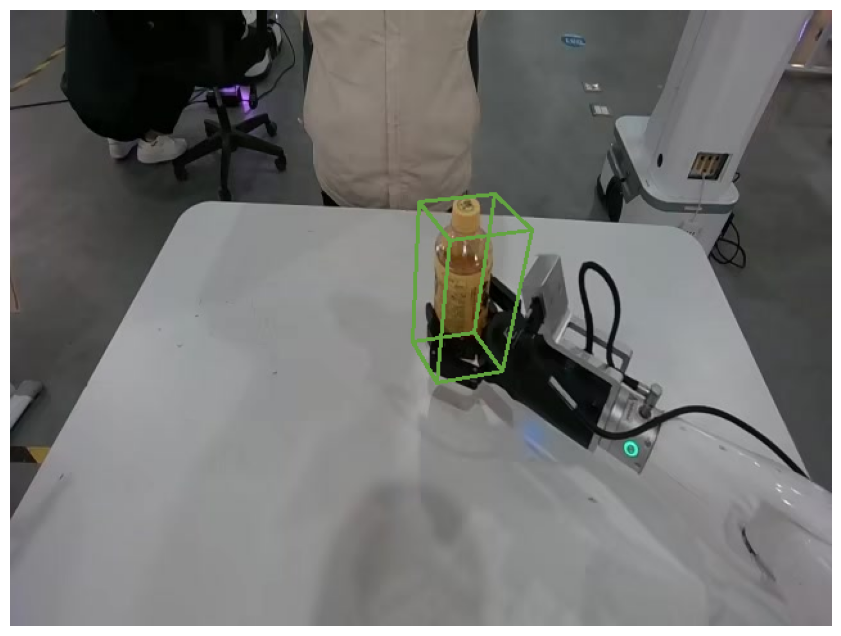

In [34]:
# Display the 3D bounding boxes visualization in notebook
fig = draw_3dbboxes(image_path, cam_params, bbox_3d_results)
if fig is not None:
    plt.show()
